In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Practical session 7: Data Visualization

<div class="alert alert-block alert-info">
    <h2>Table of Contents </h2><a class="anchor" id="top"></a>
    <br><a href="#section_1">1. Exploring a biological dataset</a>
    <br>&nbsp;&nbsp;&nbsp;&nbsp;<a href="#section_1_1">1.1 Distributions</a>
    <br>&nbsp;&nbsp;&nbsp;&nbsp;<a href="#section_1_2">1.2 UMAP</a>
    <br>&nbsp;&nbsp;&nbsp;&nbsp;<a href="#section_1_3">1.3 Cell type proportions</a>
    <br><a href="#section_2">2. Scalability</a>
    <br>&nbsp;&nbsp;&nbsp;&nbsp;<a href="#section_2_1">2.1 Measuring runtimes</a>
    <br>&nbsp;&nbsp;&nbsp;&nbsp;<a href="#section_2_2">2.2 Plotting runtimes</a>
</div>

The principal plotting library in Python is [matplotlib](https://matplotlib.org/stable/plot_types/index.html), but other great visualization libraries also exist:

* [seaborn](http://seaborn.pydata.org/tutorial.html)
* [bokeh](https://docs.bokeh.org/en/latest/docs/first_steps.html#first-steps), often used for interactive plots
* [plotnine](https://plotnine.readthedocs.io/en/stable/), a port of ggplot2 from R

For this session we recommend mainly using seaborn. However, it is possible to create the same plots with any library, so don't be afraid to experiment! Finally, in addition to the documentation, cheat sheets are also a good way to get an overview (and be reminded) of how to customize plots [[matplotlib](https://matplotlib.org/cheatsheets/), [seaborn](https://www.datacamp.com/cheat-sheet/python-seaborn-cheat-sheet)].

<h2 style="display: inline"> 1. Exploring a biological dataset </h2> <span style="float: right"><a href="#top">[back to top]</a></span> <a class="anchor" id="section_1"></a> 

We will be using a dataset of mouse liver cells from [Guilliams et al. (2022)](https://www.sciencedirect.com/science/article/pii/S0092867421014811). The researchers performed single-cell RNA sequencing on mice liver, allowing us to know the RNA content of each liver cell. This dataset has been preprocessed and contains the following information for each cell:
* `cell_id`: unique identifier
* `nCount_RNA`: total number of RNA transcripts
* `nFeature_RNA`: total number of genes
* `UMAP_1`: x-coordinate of the cell in the UMAP space (UMAP = non-linear PCA)
* `UMAP_2`: y-coordinate of the cell in the UMAP space
* `sample`: the mice that the cell was obtained from
* `celltype`: cell type annotation

In the following sections, we will visualize some characteristics of the data. Consider which type of plot(s) would be best for each task. Also, try to optimize the presentation of your plot based on what you have learned during the lectures.

In [2]:
# Read in data
# data_path = "/data/gent/shared/000/gvo00070/BigDataScience2023/"
data_path = ""
liver = pd.read_csv(data_path + "mouse_liver.csv")

In [3]:
liver.head()

,cell_id,nCount_RNA,nFeature_RNA,UMAP_1,UMAP_2,sample,celltype
0,AAACCCAAGCATACTC-1,5916,2430,2.903706,0.226963,ABU7,Endothelial
1,AAACGCTGTTCTATCT-1,1003,491,2.812009,7.360530,ABU7,Hepatocytes
2,AAAGAACCAACGCCCA-1,10981,3727,1.410986,8.400421,ABU7,Hepatocytes
3,AAAGAACCAATAACGA-1,2280,1182,4.396062,11.609945,ABU7,KCs
4,AAAGAACTCCACACAA-1,5131,2157,8.277985,4.458262,ABU7,Fibroblasts


<h3 style="display: inline"> 1.1 Distributions </h3> <span style="float: right"><a href="#top">[back to top]</a></span> <a class="anchor" id="section_1_1"></a> 

<div class="alert alert-success">
<h3> Exercise</h3>
    <br> Visualize the following in separate plots:
    <ol>
        <li> The distribution of number of RNA transcripts per cell type (<code>nCount_RNA</code>).
        <li> The distribution of number of genes per cell type (<code>nFeature_RNA</code>).
    </ol>
</div>

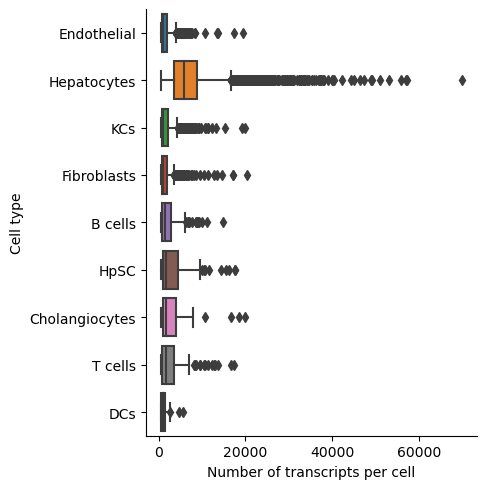

In [4]:
# Plot distribution of RNA transcripts per cell type
# Can also set kind="violin"
ax = sns.catplot(data=liver, x="nCount_RNA", y="celltype", kind="box")
ax.set(xlabel='Number of transcripts per cell', ylabel='Cell type')
plt.show()

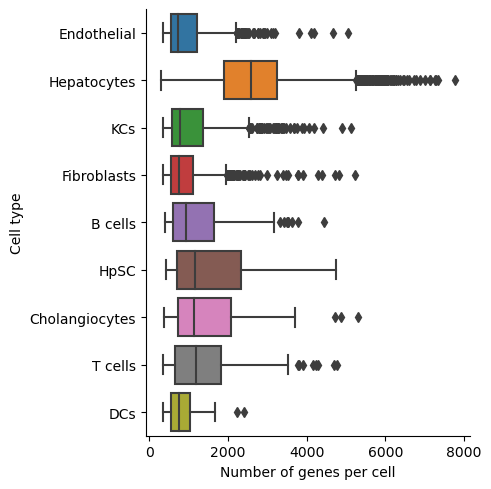

In [5]:
# Plot distribution of genes per cell type
ax = sns.catplot(data=liver, x="nFeature_RNA", y="celltype", kind="box")
ax.set(xlabel='Number of genes per cell', ylabel='Cell type')
plt.show()

<div class="alert alert-block alert-warning">
    Which cell type has the highest number of transcripts and genes on average? <br>
    <b>Answer:</b> Hepatocytes.
</div>

<h3 style="display: inline"> 1.2 UMAP </h3> <span style="float: right"><a href="#top">[back to top]</a></span> <a class="anchor" id="section_1_2"></a> 

<div class="alert alert-success">
<h3> Exercise</h3>
    <br> Create a UMAP plot of the cells colored by its cell type.
</div>

As mentioned above, you can think of a UMAP as a non-linear variant of the PCA. The UMAP preserves the global structure of the data points, and often cell types that are closer together in the UMAP are more similar than those that are farther apart.

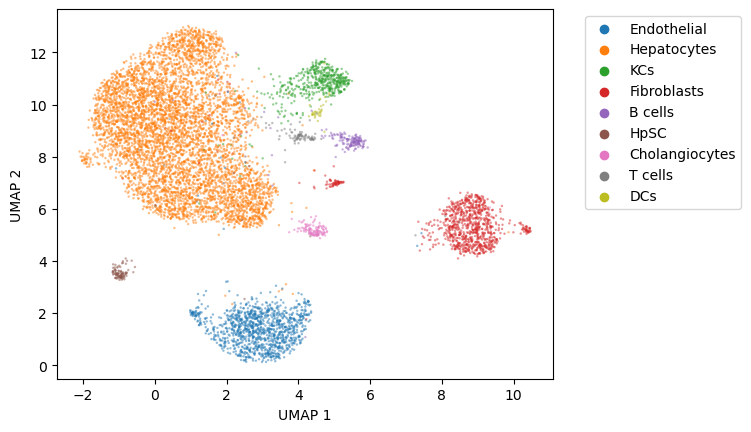

In [6]:
ax = sns.scatterplot(data=liver, x='UMAP_1', y='UMAP_2', hue='celltype',
               s=3, alpha=0.5, edgecolor='none')

# Add axis labels
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

ax.legend(bbox_to_anchor=(1.05, 1))

# Show the plot
plt.show()

<div class="alert alert-block alert-warning">
    Which cell type seems to be the most different from other cell types? Try to quantify this based on the UMAP coordinates. <br>
    <b>Answer:</b> HpSCs are on average the furthest from other cell types.
</div>

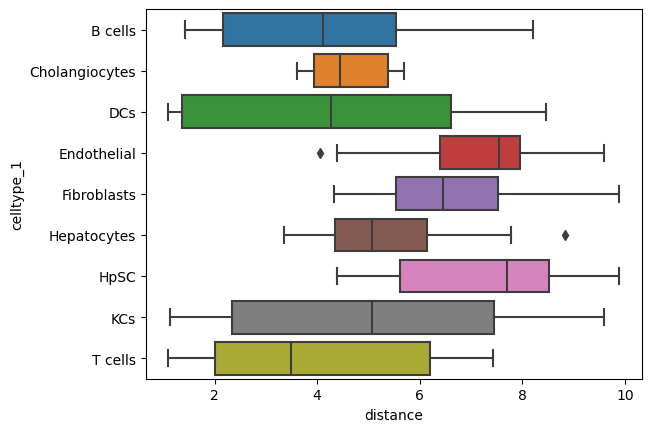

In [7]:
from sklearn.metrics import pairwise_distances

# calculate centroids for each cell type
centroids = liver.groupby('celltype')[['UMAP_1', 'UMAP_2']].median()

# calculate pairwise distances between centroids
distances = pd.DataFrame(pairwise_distances(centroids),
                         columns=centroids.index.rename('source'),
                         index=centroids.index).stack().reset_index()

distances.columns = ['celltype_1', 'celltype_2', 'distance']
distances = distances[distances['celltype_1'] != distances['celltype_2']]

sns.boxplot(y='celltype_1', x='distance', data=distances)
plt.show()

<h3 style="display: inline"> 1.3 Cell type proportions </h3> <span style="float: right"><a href="#top">[back to top]</a></span> <a class="anchor" id="section_1_3"></a> 

It is important to also check if we obtain similar cell type proportions for each sample (i.e., mice), to confirm whether the experiment worked well for all samples. For this, we first have to count the number of each cell type per sample:

In [8]:
# Method 1
# Count the number of each celltype per sample and store this in a column called 'n'
liver_counts = liver.groupby(['sample', 'celltype']).size().reset_index(name='n')

# For some plotting functions, you may also need to calculate the proportions yourself
liver_counts['props'] = liver_counts.groupby('sample', group_keys=False)['n'].apply(lambda x: x / x.sum())
liver_counts.head()

# Alternative to getting only proportions - use value_counts(with normalize=True)
# liver_counts = liver.groupby(['sample']).value_counts(['celltype'], normalize=True).unstack().reset_index()
# liver_counts = pd.melt(liver_counts, id_vars = 'sample', var_name='celltype', value_name='proportion')

,sample,celltype,n,props
0,ABU17,B cells,40,0.022923
1,ABU17,Cholangiocytes,22,0.012607
2,ABU17,DCs,4,0.002292
3,ABU17,Endothelial,267,0.153009
4,ABU17,Fibroblasts,243,0.139255


<div class="alert alert-success">
<h3> Exercise</h3>
    <br> Plot the proportions of each cell type per sample.
</div>

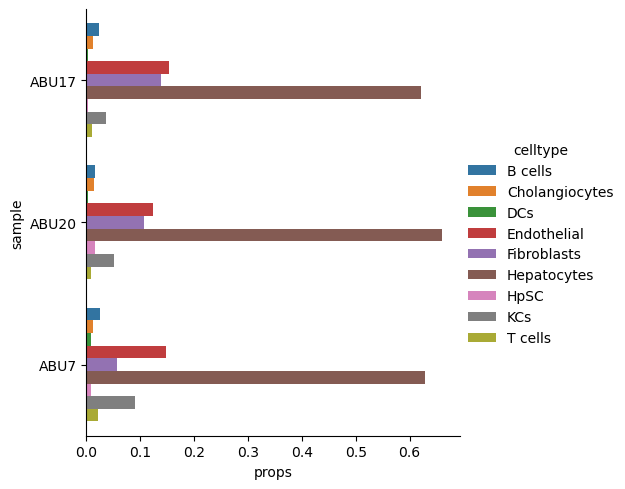

In [9]:
# Method 1: bar plot with Seaborn
sns.catplot(x='props', y='sample', hue='celltype', kind='bar', data=liver_counts)
plt.show()

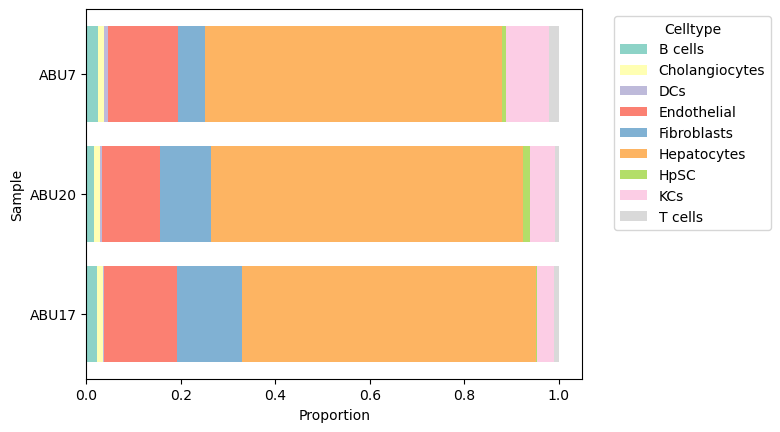

In [10]:
# Method 2: stacked bar plot with matplotlib
import matplotlib as mpl
fig, ax = plt.subplots()

# Get a list of unique sample names and cell types
samples = liver_counts['sample'].unique()
celltypes = liver_counts['celltype'].unique()

# Use colors from the 'Set3' colormap
colors = mpl.colormaps['Set3'].colors[:len(celltypes)]

# Loop over each sample and plot the stacked bar chart
bottom = np.zeros(len(samples))
for celltype, color in list(zip(celltypes, colors)):
    values = liver_counts.loc[liver_counts['celltype'] == celltype]['props']
    ax.barh(samples, values, color=color, left=bottom)
    bottom += values.values
    
# Add the legend and set axis labels
ax.legend(celltypes, title = 'Celltype', bbox_to_anchor=(1.05, 1))
ax.set_xlabel('Proportion')
ax.set_ylabel('Sample')

# Show the plot
plt.show()

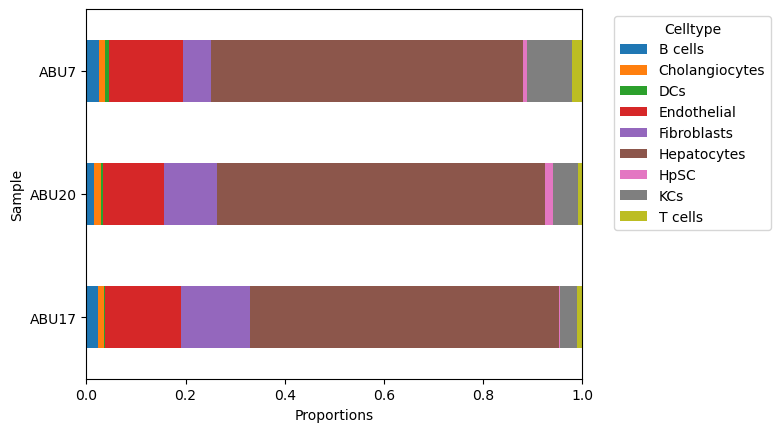

In [11]:
# Method 3: Plot directly using pandas' plotting capabilities (matplotlib backend)
# This uses a slightly different input, but the code is cleaner
annot_total = liver_counts.groupby('sample')['n'].sum()
annot_props = liver_counts.groupby(['sample', 'celltype'])['n'].sum() / annot_total

ax = annot_props.unstack().plot.barh(stacked=True)

# Adjust the axis
ax.set_xlabel('Proportions')
ax.set_ylabel('Sample')
ax.set_xlim(0, 1.0)
ax.legend(title='Celltype', bbox_to_anchor=(1.05, 1))
plt.show()

<h2 style="display: inline">2. Scalability</h2> <span style="float: right"><a href="#top">[back to top]</a></span> <a class="anchor" id="section_2"></a> 

One important aspect of big data is how well different algorithms scale. We can visualise this by plotting run times against data set sizes. When talking about run times, it’s important to distinguish between the time required to construct/fit a model (construction time) and the time required to predict results with this model (query time).

As we need a bigger dataset for this exercise, instead of using a toy dataset, we will make use of sklearn's [`fetch_openml`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_openml.html) function to fetch a dataset from the OpenML repository. We will use the MiniBooNE dataset, which is used to distinguish electron neutrinos (signal) from muon neutrinos (background).

In [12]:
from sklearn.datasets import fetch_openml
X, y = fetch_openml(name='miniboone', version=1, parser="auto", return_X_y=True)

<div class="alert alert-block alert-warning">
    How many features are in this dataset? How many samples? How many classes?
</div>

It’s generally most informative to use logarithmic axes when measuring runtimes, so we will vary the training set size in powers of two, from 2<sup>3</sup> until 2<sup>15</sup>. We will measure the scalability of four classifiers: Nearest Neighbours, Support Vector Machine, Classification and Regression Tree (CART) and Random Forest. We will use these models to predict 1000 test instances and divide the resulting times by 1000 to obtain the query time per instance. This gives us more robust results, as it is generally safe to assume that there is a linear dependency between the number of test instances and query time.

In [13]:
# Import all models
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Use the same random state for reproducibility, even though we are not interested
# in the prediction results here.
random_state = 0

# Create empty lists to store the results
classifier_list = []
p_list = []
construction_time_list = []
query_time_list = []

# Create tuple of classifiers
classifiers = [
    ('KNN', KNeighborsClassifier()),
    ('SVM', SVC()),
    ('CART', DecisionTreeClassifier(random_state=random_state)),
    ('Random Forest', RandomForestClassifier(random_state=random_state))
]

# Select 1000 test instances
# Note that they are stratified, so the classes are balanced
X_train_pool, X_test, y_train_pool, y_test = train_test_split(
    X, y, test_size=1000, stratify=y, random_state=random_state
)

<h3 style="display: inline"> 2.1 Measuring runtimes </h3> <span style="float: right"><a href="#top">[back to top]</a></span> <a class="anchor" id="section_2_1"></a> 

<div class="alert alert-success">
<h3> Exercise</h3>
    <br>Measure construction and query times for different training set sizes.

<b>Hint:</b> To measure time, start with <code>from datetime import datetime</code>, and use <code>datetime.now()</code> at the start and end of the section of code that you want to time. If you subtract these values from each other, you obtain the duration, which you can convert into the number of seconds with <code>(end_time-start_time).total_seconds()</code>.
</div>


In [14]:
from datetime import datetime

# Iterate over the powers of 2 that we will use
for p in range(3, 16):
    print('Current loop: 2^{}'.format(p))
    
    # Stratify by 'y_train_pool' to ensure our training set contains instances from both classes.
    X_train, _, y_train, _ = train_test_split(
        X_train_pool, y_train_pool, train_size=2**p, stratify=y_train_pool, random_state=random_state
    )

    for clf_name, clf in classifiers:
        # Measure construction time
        fit_start_time = datetime.now()
        model = clf.fit(X_train, y_train)
        construction_time = (datetime.now() - fit_start_time).total_seconds()
        
        # Measure query time
        predict_start_time = datetime.now()
        model.predict(X_test)
        query_time = (datetime.now() - predict_start_time).total_seconds()
        
        # Store results
        classifier_list.append(clf_name)
        p_list.append(p)
        construction_time_list.append(construction_time)
        query_time_list.append(query_time/1000)

        
# Create a dictionary to store the results
results_dict = {'classifier': classifier_list,
                'p': p_list,
                'construction_time': construction_time_list,
                'query_time': query_time_list}

# Convert the dictionary to a DataFrame
results_df = pd.DataFrame(results_dict)

Current loop: 2^3
Current loop: 2^4
Current loop: 2^5
Current loop: 2^6
Current loop: 2^7
Current loop: 2^8
Current loop: 2^9
Current loop: 2^10
Current loop: 2^11
Current loop: 2^12
Current loop: 2^13
Current loop: 2^14
Current loop: 2^15


In [15]:
results_df.head(10)

,classifier,p,construction_time,query_time
0,KNN,3,0.001207,4.075200e-05
1,SVM,3,0.001223,9.350000e-07
2,CART,3,0.001081,6.690000e-07
3,Random Forest,3,0.061193,6.422000e-06
4,KNN,4,0.001071,1.257800e-05
5,SVM,4,0.001192,1.142000e-06
6,CART,4,0.001026,6.210000e-07
7,Random Forest,4,0.061894,6.742000e-06
8,KNN,5,0.001061,1.113500e-05
9,SVM,5,0.001150,1.507000e-06


<h3 style="display: inline"> 2.2 Plotting runtimes </h3> <span style="float: right"><a href="#top">[back to top]</a></span> <a class="anchor" id="section_2_2"></a> 

Although we could already use the `results_df` dataframe to create a plot of the runtimes per classifier, it would require the use of a `for` loop. A more elegant solution - and something you would often have to do in data wrangling - is to pivot the dataframe from its **long** format to a **wide** one.  Consider the example below from [Towards Data Science](https://towardsdatascience.com/reshaping-a-pandas-dataframe-long-to-wide-and-vice-versa-517c7f0995ad):

![dataframe](./long_vs_wide.webp)

> The dataframe on the left is structured in a **long** format: each food category (‘Item’) has multiple repeating rows, each of which represents a specific year/month and the average food price corresponding to that year/month. Though we only have 5 food categories (‘items’), we have a total of 139 rows, making the dataframe a **long** shape.
>
> In contrast, the dataframe on the right has a **wide** format — more like a spreadsheet-style format. In this format, each row represents a unique food category. We pivot the ‘Year Month’ column in the left dataframe so that each month is in a separate column — making the right dataframe a ‘wide’ shape. The values of the ‘Year Month’ column in the left table now become the column names in the right table and we have the ‘avg. price’ for each Month/Year column accordingly.

Pandas offers the [`pd.pivot`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.pivot.html) function which helps us transpose between the two formats. In the example above, this can be achieved using:

> <code> df_wide = pd.pivot(df_long, index=['Series ID','Item'], columns = 'Year Month',
    values = 'Avg. Price ($)') </code>

<div class="alert alert-success">
<h3> Exercise</h3>
    <br>Pivot the <code>results_df</code> to a wide format, with each classifier on the columns and the <b>construction time</b> as values. Then, visualize the construction time per classifier across training set sizes. It is also recommended to set the y-axis on a logarithmic scale.
</div>

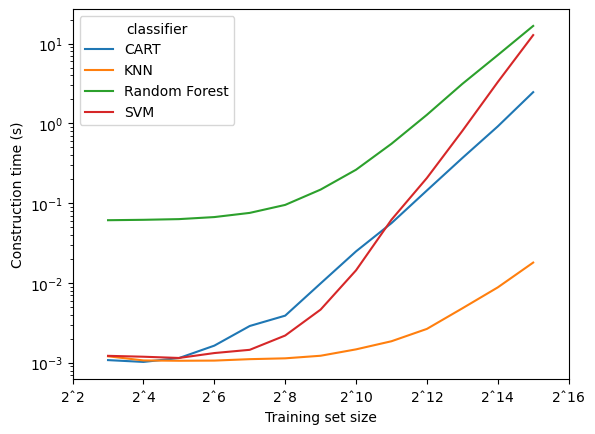

In [16]:
# Pivot to obtain columns that correspond to the different classifiers
construction_time = results_df.pivot(index='p', columns='classifier', values='construction_time')

# Plot construction times
construction_time.plot()

# Set y-axis to logarithmic scale
axes = plt.gca()
axes.set_yscale('log', base=10)

# Format ticks and labels
xticks = axes.get_xticks()
labels = [int(xticks) for xticks in xticks]
axes.set_xticks(xticks)
axes.set_xticklabels(['$\mathregular{{2ˆ{{{}}}}}$'.format(labels) for labels in labels])

# Set axis labels and save the plot
axes.set_xlabel('Training set size')
axes.set_ylabel('Construction time (s)')
plt.show()

<div class="alert alert-success">
<h3> Exercise</h3>
    <br>Follow the same strategy as above but with using <b>query time</b> as values.
</div>

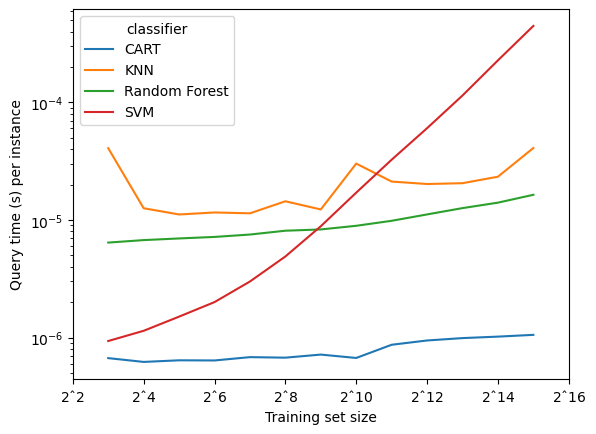

In [17]:
# Pivot to obtain columns that correspond to the different classifiers
query_times = results_df.pivot(index='p', columns='classifier', values='query_time')

# Plot query times
query_times.plot()

# Set y-axis to logarithmic scale
axes = plt.gca()
axes.set_yscale('log', base=10)

# Format ticks and labels
xticks = axes.get_xticks()
labels = [int(xticks) for xticks in xticks]
axes.set_xticks(xticks)
axes.set_xticklabels(['$\mathregular{{2ˆ{{{}}}}}$'.format(labels) for labels in labels])

# Set axis labels and save the plot
axes.set_xlabel('Training set size')
axes.set_ylabel('Query time (s) per instance')
plt.show()